In [1]:
import graph.util as U
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, Flatten
from keras.models import Sequential
import cv2
%matplotlib inline

Using TensorFlow backend.


In [2]:
with open('./scenes/kitchen-84.pkl', 'rb') as f:
    graph = U.load_graph(f)

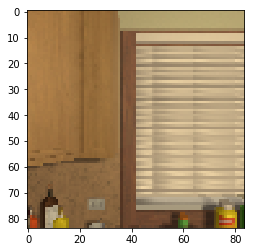

In [3]:
graph.graph[:,:, 1,1]
plt.imshow(graph.render((1,1),3))
plt.show()

goal = (1,1)

In [4]:
model = Sequential(layers = [
    Conv2D(
        input_shape = (84, 84, 3),
        filters=32,
        kernel_size=[8,8],
        strides=[4,4],
        padding = 'valid',
        activation="relu"),

    Conv2D(
        filters=32,
        kernel_size=[4,4],
        strides=[2,2],
        padding = 'valid',
        activation="relu"),
    
    Flatten(),
    Dense(512, activation = 'relu'),
    Dense(4 + 368, activation = 'softmax')
])

model.compile(optimizer = 'SGD', loss='binary_crossentropy', metrics = ['accuracy'])

In [5]:
dataset = []
actions = []
oa = dict()

def compute_actions(graph, goal, state):
    rotations = np.abs(np.where(graph.optimal_actions[state[:2] + goal])[0] - state[2])
    assert len(rotations) > 0
    rotation = min(rotations, key = lambda x: x if x != 3 else 1)
    if rotation == 2:
        return [0.0, 1.0, 0.0, 0.]
    if rotation == 0:
        return [1.0, 0., 0., 0.]
    if rotation == 1:
        return [0., 1., 0., 0.]
    if rotation == 3:
        return [0., 0., 0., 1.]
    

for pos in U.enumerate_positions(graph.maze):
    if graph.graph[pos + goal] <= 0:
        continue
    for r in range(4):
        dataset.append(graph.render(pos, r))
        actions.append(compute_actions(graph, goal, pos + (r,)))
        oa[pos + (r,)] = compute_actions(graph, goal, pos + (r,))

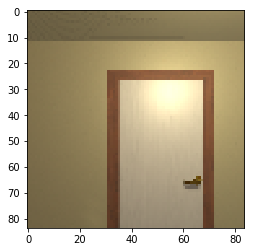

[3]


In [6]:
graph.graph[:,:, 1,1]
plt.imshow(graph.render((1,4),0))
plt.show()

state = (1,4,0)
rotations = np.abs(np.where(graph.optimal_actions[state[:2] + goal])[0] - state[2])
print(rotations)

In [7]:
X = np.ndarray.astype(np.stack(dataset, axis = 0), np.float32)
Y = np.concatenate([np.ndarray.astype(np.stack(actions, axis = 0), np.float32), np.eye(368, dtype = np.float32)], 1)

model.fit(X, Y, epochs = 20, shuffle = True)

Epoch 1/20
368/368 [==============================] - 1s 4ms/step - loss: 0.1151 - acc: 0.9920
Epoch 2/20
368/368 [==============================] - 0s 829us/step - loss: 0.1196 - acc: 0.9920
Epoch 3/20
368/368 [==============================] - 0s 951us/step - loss: 0.1098 - acc: 0.9920
Epoch 4/20
368/368 [==============================] - 0s 923us/step - loss: 0.0946 - acc: 0.9923
Epoch 5/20
368/368 [==============================] - 0s 767us/step - loss: 0.0910 - acc: 0.9927
Epoch 6/20
368/368 [==============================] - 0s 858us/step - loss: 0.0892 - acc: 0.9929
Epoch 7/20
368/368 [==============================] - 0s 878us/step - loss: 0.0866 - acc: 0.9932
Epoch 8/20
368/368 [==============================] - 0s 893us/step - loss: 0.0698 - acc: 0.9936
Epoch 9/20
368/368 [==============================] - 0s 947us/step - loss: 0.0528 - acc: 0.9942
Epoch 10/20
368/368 [==============================] - 0s 841us/step - loss: 0.0441 - acc: 0.9945
Epoch 11/20
368/368 [==========

In [8]:
from eval import Evaluation
import gym
import gym.wrappers
from graph.env import GraphEnv

class Agent:
    def __init__(self):
        self.name = 'supervised'
    def act(self, state):

        return np.argmax(compute_actions(graph, self.env.goal, self.env.state))
        # v = np.argmax(model.predict(np.expand_dims(state, 0))[...,:4])
        # return v

    def reset_state(self):
        pass
    
    def wrap_env(self, env):
        self.env = env
        return gym.wrappers.TimeLimit(env, max_episode_steps = 50)

env = GraphEnv(graph, goal)
evaluation = Evaluation(env)
evaluation.run(Agent())


ImportError: cannot import name 'GraphEnv'

In [ ]:
evaluation.results